In [1]:
#get started by loading the relevant libraries, not sure all of them are needed, I collected them throughout my trials
import pandas as pd
import matplotlib.pyplot as plt
import pathlib2 as pathlib
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN

In [2]:
#setting the path
cwd=pathlib.Path.cwd()
datadirpath=cwd.joinpath("data")
rawdatapath=datadirpath.joinpath("raw")

In [3]:
user_ratings_df=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
user_ratings_df=user_ratings_df.drop([user_ratings_df.columns[0]],axis=1) # removed unnamed index column
print(user_ratings_df.columns)
print(user_ratings_df.head)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')
<bound method NDFrame.head of                      title  book_id  user_id_mapping  book_id_mapping  \
0       I Am the Messenger    19057             1537              299   
1       I Am the Messenger    19057            23039              299   
2       I Am the Messenger    19057            39096              299   
3       I Am the Messenger    19057            14631              299   
4       I Am the Messenger    19057            32816              299   
...                    ...      ...              ...              ...   
196291            Coraline    17061            58417              106   
196292            Coraline    17061             9941              106   
196293            Coraline    17061            31383              106   
196294            Coraline    17061            33833              106   
196295            Coraline    17061

In [4]:
# Count unique entries in 'column_name'
unique_count = user_ratings_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count}")

Number of unique entries: 66909


In [5]:
book_metadata_df=pd.read_csv(rawdatapath.joinpath("collaborative_book_metadata.csv"))
book_metadata_df=book_metadata_df.drop([book_metadata_df.columns[0]],axis=1) # removed unnamed index column
print(book_metadata_df.columns)
print(book_metadata_df.head)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')
<bound method NDFrame.head of      book_id                                              title  \
0    5899779  Pride and Prejudice and Zombies Pride and Prej...   
1     872333                          Blue Bloods Blue Bloods 1   
2   15507958                      Me Before You Me Before You 1   
3      66559                                      Sharp Objects   
4    7235533          The Way of Kings The Stormlight Archive 1   
..       ...                                                ...   
91  10600242                                  How to Be a Woman   
92      9516   Persepolis The Story of a Childhood Persepolis 1   
93    307791                  The City of Ember Book of Ember 1   
94     37442  Wicked The Life and Times of the Wicked Witch ...   
95  29069989  Harry Potter and the Cursed Child Parts 1 2 Ha...   

       

In [7]:
import re

# Define a function to clean up genre names
def clean_genre(genre):
    if pd.isna(genre):
        return ''
    genre = genre.strip()
    genre = re.sub(r"[^\w\s,]", "", genre)  # Remove any non-alphanumeric characters except commas and spaces
    genre = genre.replace("'", "")          # Remove single quotes
    genre = genre.replace("[", "")          # Remove square brackets
    genre = genre.replace("]", "")
    genre = genre.replace(",", ", ")        # Normalize spaces around commas
    return genre

# Apply the cleaning function to the genre column
book_metadata_df['cleaned_genre'] = book_metadata_df['genre'].apply(clean_genre)

# Display cleaned genres to verify
print("Cleaned Genres:")
print(book_metadata_df['cleaned_genre'].unique())


Cleaned Genres:
['fantasy,  paranormal,  romance,  fiction,  history,  historical fiction,  biography,  youngadult,  mystery,  thriller,  crime'
 'youngadult,  fantasy,  paranormal,  romance,  fiction,  mystery,  thriller,  crime'
 'romance,  fiction' 'mystery,  thriller,  crime,  fiction'
 'fantasy,  paranormal,  fiction'
 'fiction,  mystery,  thriller,  crime,  fantasy,  paranormal'
 'fantasy,  paranormal,  fiction,  history,  historical fiction,  biography'
 'fantasy,  paranormal,  fiction,  youngadult'
 'fantasy,  paranormal,  fiction,  youngadult,  romance'
 'fiction,  romance' 'fiction,  fantasy,  paranormal,  youngadult'
 'fiction,  poetry,  history,  historical fiction,  biography,  nonfiction,  romance,  youngadult'
 'fantasy,  paranormal,  fiction,  romance,  mystery,  thriller,  crime,  youngadult'
 'fantasy,  paranormal,  youngadult,  fiction,  children,  romance,  mystery,  thriller,  crime'
 'fantasy,  paranormal,  fiction,  youngadult,  children,  mystery,  thriller,  cr

In [8]:
# One-hot encode the cleaned genre column
genre_dummies = book_metadata_df['cleaned_genre'].str.get_dummies(sep=', ')

# Combine the one-hot encoded genres with the book metadata
book_metadata_df = pd.concat([book_metadata_df, genre_dummies], axis=1)

# Drop the original genre and cleaned_genre columns if not needed
book_metadata_df = book_metadata_df.drop(columns=['genre', 'cleaned_genre'])

# Display the processed book metadata to check the new columns
print("Processed Book Metadata DataFrame Head:")
print(book_metadata_df.head())

Processed Book Metadata DataFrame Head:
    book_id                                              title  \
0   5899779  Pride and Prejudice and Zombies Pride and Prej...   
1    872333                          Blue Bloods Blue Bloods 1   
2  15507958                      Me Before You Me Before You 1   
3     66559                                      Sharp Objects   
4   7235533          The Way of Kings The Stormlight Archive 1   

                                           image_url  \
0  https://images.gr-assets.com/books/1320449653m...   
1  https://images.gr-assets.com/books/1322281515m...   
2  https://images.gr-assets.com/books/1357108762m...   
3  https://images.gr-assets.com/books/1423241485m...   
4  https://images.gr-assets.com/books/1507307887m...   

                                                 url  num_pages  \
0  https://www.goodreads.com/book/show/5899779-pr...        320   
1  https://www.goodreads.com/book/show/872333.Blu...        302   
2  https://www.goodreads.

In [9]:
print(book_metadata_df.columns)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'name', 'book_id_mapping', ' biography', ' children',
       ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [10]:
# Step 4: Merge the user ratings DataFrame with the book metadata DataFrame
# Use 'book_id_mapping' as the common key, and only keep rows with metadata

# Merge the DataFrames
merged_df = pd.merge(user_ratings_df, book_metadata_df, on='book_id_mapping', how='inner')

# The 'inner' join ensures that only rows with matching 'book_id_mapping' in both DataFrames are kept.
# This automatically removes any rows from user_ratings_df that do not have corresponding metadata.

# Display the cleaned and merged DataFrame to verify
print("Merged and Filtered DataFrame Head:")
print(merged_df.head())

Merged and Filtered DataFrame Head:
                      title_x  book_id_x  user_id_mapping  book_id_mapping  \
0  We Should All Be Feminists   22738563            64847              873   
1  We Should All Be Feminists   22738563            45548              873   
2  We Should All Be Feminists   22738563             9063              873   
3  We Should All Be Feminists   22738563            27200              873   
4  We Should All Be Feminists   22738563            41888              873   

   Predicted Rating  Actual Rating  book_id_y  \
0               4.0              5    7235533   
1               4.1              4    7235533   
2               4.5              5    7235533   
3               4.2              5    7235533   
4               4.4              5    7235533   

                                     title_y  \
0  The Way of Kings The Stormlight Archive 1   
1  The Way of Kings The Stormlight Archive 1   
2  The Way of Kings The Stormlight Archive 1   
3  The W

In [31]:
print(merged_df.shape)

(19824, 39)


In [11]:
# Count unique entries in 'column_name'
unique_count1 = merged_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count1}")

Number of unique entries: 17103


In [12]:
#another try for step5
import pandas as pd
from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genre dummies)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalize the vectors (optional)
#user_vectors_normalized = pd.DataFrame(
#    normalize(user_vectors, norm='l2'),
#    index=user_vectors.index,
#    columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
print("Aggregated and Normalized User Vectors Head:")
print(user_vectors.head())

Aggregated and Normalized User Vectors Head:
                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0  

In [27]:
print(user_vectors.shape)
print(user_vectors.columns)

(17103, 27)
Index(['num_pages', 'ratings_count', ' biography', ' children', ' comics',
       ' crime', ' fantasy', ' fiction', ' graphic', ' historical fiction',
       ' history', ' mystery', ' nonfiction', ' paranormal', ' poetry',
       ' romance', ' thriller', ' youngadult', 'children', 'comics', 'fantasy',
       'fiction', 'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


In [28]:



# Standardize the data (important for DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_vectors)

In [14]:
from sklearn.preprocessing import StandardScaler

In [75]:
# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=2.5, min_samples=3)

# Fit the model to the scaled data

clusters = dbscan.fit_predict(X_scaled)

# The labels assigned to each data point (cluster ID, -1 for noise)
labels = dbscan.labels_

# Add cluster labels to the original DataFrame
user_vectors['cluster'] = clusters

In [76]:
# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise points
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 14
Estimated number of noise points: 69


In [51]:
# with eps =1 und min samples = 5 haben wir einen silhousett score von 0,379. 
# #Noch nicht grandios aber je nach data set akzeptabel

from sklearn.metrics import silhouette_score

# Calculate silhouette score (ignoring noise)
silhouette = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else -1
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.7761218900965361


In [22]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [25]:
#random search cv durchlaufen lassen

# Suppress all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN()

param_dist = {
    'eps': np.linspace(1, 5, 5),  # Epsilon parameter: distance that defines neighborhood
    'min_samples': range(2, 20)        # Minimum samples to form a cluster
}

from sklearn.metrics import adjusted_rand_score

def ari_scorer(estimator, X, y_true):
    cluster_labels = estimator.fit_predict(X)
    if len(set(cluster_labels)) > 1:  # Ensure there's more than one cluster
        return adjusted_rand_score(y_true, cluster_labels)
    else:
        return -1  # Assign a low score if clustering is trivial

# Example usage in RandomizedSearchCV
ari = make_scorer(ari_scorer, needs_proba=False)


# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=dbscan,
    param_distributions=param_dist,
    n_iter=100,                   # Number of parameter settings to sample
    scoring=ari,           # Use the custom silhouette scoring function
    cv=3,                         # Number of folds (not used, but required by RandomizedSearchCV)
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_scaled, y_true) 

# Best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Silhouette Score:", random_search.best_score_)

NameError: name 'y_true' is not defined

In [69]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, silhouette_score
import numpy as np
import pandas as pd

# Assuming you already have the user_vectors DataFrame
# Prepare the data by dropping any non-feature columns (if necessary)
X = user_vectors.values  # Use all features for clustering

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN model
dbscan = DBSCAN()

# Hyperparameter grid
param_dist = {
    'eps': np.linspace(1, 5, 5),  # Epsilon parameter
    'min_samples': range(10, 30)   # Minimum samples to form a cluster
}

# Define custom scorer using Silhouette Score (no need for true labels)
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    if len(set(cluster_labels)) > 1:  # Ensure there's more than x cluster
        return silhouette_score(X, cluster_labels)
    else:
        return -1  # Assign a low score if clustering is trivial (only one cluster)

# Create a custom scorer for silhouette score
silhouette = make_scorer(silhouette_scorer)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=dbscan,
    param_distributions=param_dist,
    n_iter=20,  # Adjust based on the search space
    scoring=silhouette,  # Use silhouette score for unsupervised evaluation
    cv=3,                 # Cross-validation (not applicable to DBSCAN, but required by RandomizedSearchCV)
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_scaled)

# Best hyperparameters and corresponding score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Silhouette Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^

Best Hyperparameters: {'min_samples': 13, 'eps': 5.0}
Best Silhouette Score: nan


In [34]:
#not needed? alternative step 5, trying to combine all user data in 1 vector
#import pandas as pd
#from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
# Multiply user ratings by book metadata (for each user's rating)

# First, create a matrix where each row is a user's rating for a book combined with the book's metadata
#user_item_with_metadata = merged_df.copy()

# Assume `genre_dummies` is already merged in `merged_df` as part of the genres one-hot encoding process

# Step 2: Multiply each user's rating by the corresponding metadata like num_pages, ratings_count, and genres
# This assumes 'Actual Rating' is the column containing the user ratings

# Multiply user ratings by each metadata column
#for col in ['num_pages', 'ratings_count'] + genre_dummies.columns.tolist():
#    user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Step 3: Aggregate the vectors for each user
# Group by 'user_id_mapping' and aggregate by summing (or averaging) the vectors
#user_vectors = user_item_with_metadata.groupby('user_id_mapping').sum()

# Step 4: Normalize the vectors (optional)
# Normalize to ensure that the vector lengths are comparable regardless of the number of ratings
#user_vectors_normalized = pd.DataFrame(
#    normalize(user_vectors, norm='l2'),
 #   index=user_vectors.index,
  #  columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
#print("Aggregated and Normalized User Vectors Head:")
#print(user_vectors_normalized.head())

ValueError: could not convert string to float: 'Lolita'

In [22]:
# also not needed? step 5 is not working, is crashing the kernel
# Create a pivot table to build the user-item matrix, with users as rows and books as columns
#user_item_matrix = merged_df.pivot(index='user_id_mapping', columns='book_id_mapping', values='Actual Rating')

# Fill NaN values (users who didn't rate certain books) with 0 or another appropriate value
#user_item_matrix = user_item_matrix.fillna(0)

# Now, add metadata to this matrix
# For each metadata column, multiply the user ratings by the metadata

# Example: multiply ratings by num_pages
#for col in ['num_pages', 'ratings_count'] + genre_dummies.columns.tolist():
 #   if col in merged_df.columns:
  ##      user_item_matrix_with_metadata = merged_df.pivot(index='user_id_mapping', columns='book_id_mapping', values='Actual Rating') * merged_df[col]

# Drop metadata columns from the DataFrame if necessary, or keep them for enriched user vectors
#user_vectors = user_item_matrix_with_metadata.drop(columns=['num_pages', 'ratings_count'], errors='ignore').fillna(0)

# Transpose the matrix if necessary to have users as rows and features as columns
#user_vectors = user_vectors.T

# Display the resulting user vectors
#print("User Vectors Head:")
#print(user_vectors.head())

User Vectors Head:
user_id_mapping  2      4      7      21     23     33     42     45     \
0                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

user_id_mapping  47     55     ...  83584  83703  83918  83991  84046  84173  \
0                  0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1                  0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4                  0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

user_id_mapping  84179  84212  84260  84282  
0  

In [17]:
print(user_vectors_normalized.shape)

(17103, 27)


In [46]:
# Define the range for the number of clusters
cluster_range = range(10, 71)  # Adjust this range if needed

In [ ]:
# running several versions of elbow and silhouette with different cluster ranges (up to 70 clusters)
# leads me to decide to go forward with 25 clusters, as it seems to be a reasonable compromise of good*ish
# scores and a manageable number of clusters

In [57]:
#  optimal number of clusters determined is 25
optimal_n_clusters = 75

# Fit K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
user_vectors_normalized['cluster'] = kmeans.fit_predict(user_vectors_normalized)

In [65]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

           num_pages  ratings_count   biography   children    comics  \
cluster                                                                
-1       5471.250000   2.527798e+06    0.000000   2.500000  0.000000   
 0       1504.259532   9.894397e+05    0.908128   0.672454  0.294449   
 1        880.000000   5.147635e+06    0.000000   5.000000  0.000000   
 2        704.000000   4.118108e+06    0.000000   4.000000  0.000000   
 3       1585.000000   7.711600e+05    0.000000   0.000000  0.000000   

            crime   fantasy   fiction   graphic   historical fiction  ...  \
cluster                                                               ...   
-1       2.500000   2.50000  5.000000   0.00000             0.000000  ...   
 0       1.142659   1.05642  3.108023   0.51809             0.908128  ...   
 1       0.000000   5.00000  5.000000   0.00000             0.000000  ...   
 2       0.000000   4.00000  4.000000   0.00000             0.000000  ...   
 3       0.000000   0.00000  5.00

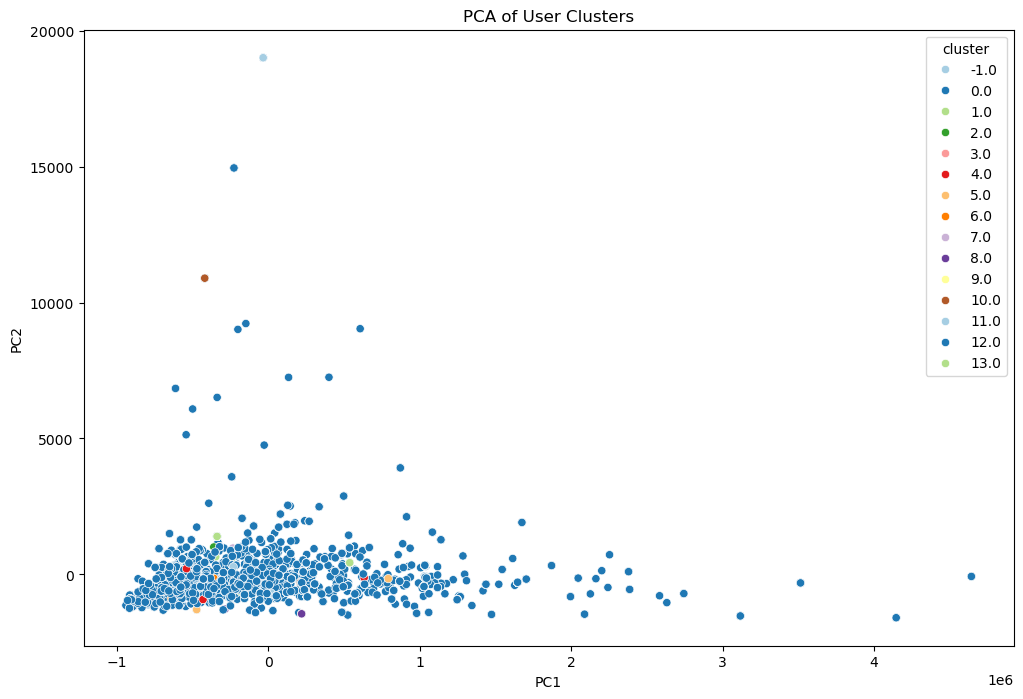

In [77]:
#initially it was viridis color palette, but that was very monotonic, changed it to Paired, still not very helpful

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.title('PCA of User Clusters')
plt.show()

In [78]:
# trying out 3d visualization, see if that helps, tried out with 25 clusters, very unsatisfying, trying with 75 clusters, not really helping either
# prepare data for it

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

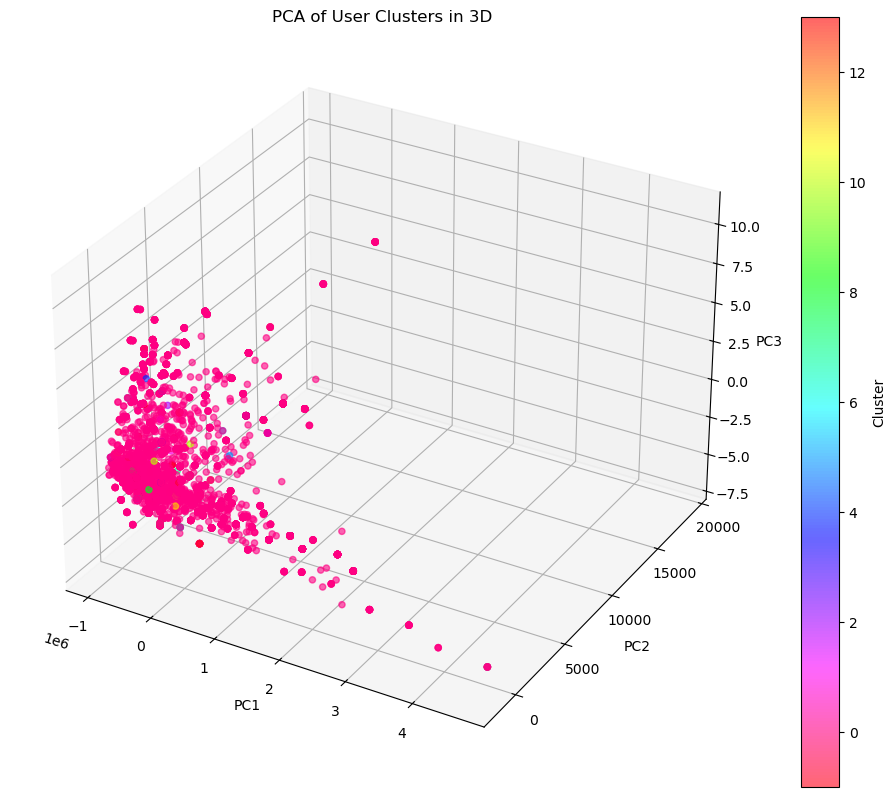

In [79]:
#create 3D scatter plot, starting with Viridis again

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='hsv_r', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()

In [70]:
# X_scaled is the normalized feature matrix
neighbors = NearestNeighbors(n_neighbors=5)  # Use 5 or set min_samples
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4], axis=0)  # 4 corresponds to k-1
plt.plot(distances)
plt.title('K-distance Graph for Eps Selection')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()

NameError: name 'NearestNeighbors' is not defined

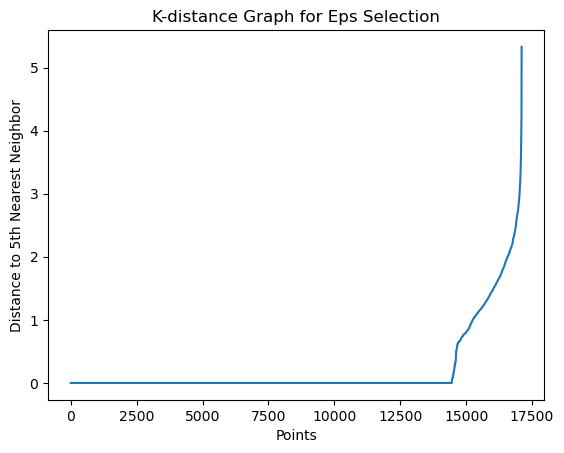

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Assuming 'user_vectors' is your DataFrame with features
# Select only the relevant columns for clustering (e.g., drop 'cluster' or non-feature columns)
features = user_vectors[['num_pages', 'ratings_count', 'biography', 'children', 'comics', 
                         'crime', 'fantasy', 'fiction', 'graphic', 'historical fiction', 
                         'history', 'mystery', 'nonfiction', 'paranormal', 'poetry', 
                         'romance', 'thriller', 'youngadult']]  # Example of selected columns

# Step 1: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 2: Define NearestNeighbors and compute distances
neighbors = NearestNeighbors(n_neighbors=5)  # Set n_neighbors to min_samples or another reasonable value
neighbors_fit = neighbors.fit(X_scaled)

# Step 3: Find the k-neighbors for each point
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Step 4: Sort the distances for k-nearest neighbors and plot
distances = np.sort(distances[:, 4], axis=0)  # 4 corresponds to the 5th nearest neighbor (index 4 = n_neighbors - 1)
plt.plot(distances)
plt.title('K-distance Graph for Eps Selection')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()

In [72]:
print(user_vectors.columns)

Index(['num_pages', 'ratings_count', ' biography', ' children', ' comics',
       ' crime', ' fantasy', ' fiction', ' graphic', ' historical fiction',
       ' history', ' mystery', ' nonfiction', ' paranormal', ' poetry',
       ' romance', ' thriller', ' youngadult', 'children', 'comics', 'fantasy',
       'fiction', 'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult',
       'cluster'],
      dtype='object')


In [73]:
# Strip leading and trailing spaces from the column names
user_vectors.columns = user_vectors.columns.str.strip()

# Verify that the column names have been cleaned
print(user_vectors.columns)

Index(['num_pages', 'ratings_count', 'biography', 'children', 'comics',
       'crime', 'fantasy', 'fiction', 'graphic', 'historical fiction',
       'history', 'mystery', 'nonfiction', 'paranormal', 'poetry', 'romance',
       'thriller', 'youngadult', 'children', 'comics', 'fantasy', 'fiction',
       'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult', 'cluster'],
      dtype='object')
